In [1]:
from sklearn.cluster import KMeans,SpectralClustering
from sklearn.metrics import silhouette_samples, silhouette_score
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Definitions

This reads our genomic CSV file.

In [2]:
def csv2X(fname):
    mypd = pd.read_csv(fname, sep=',')
    ID = list(mypd)
    X = np.transpose(mypd.values)
    return X,ID

Given cluster labels, this outputs a CSV with patient IDs.

In [3]:
def patient_cluster(ID,cluster, fname):
   """
   input: csv file of patient id, numpy array of cluster membership
   output: csv file, first column: patient id; second column: cluster membership
   """
   p_c = list(zip(ID, cluster))
   new_df = pd.DataFrame()
   new_df['patient_id'] = ID
   new_df['cluster'] = cluster
   new_df.to_csv(fname,index=None)

There are two kinds of labelers: spectral clustering and K-means The former requires a similarity matrix. These each return a function that maps the number of clusters N to a vector of the labels.

In [4]:
def SClabeler(W):
    return lambda N: SpectralClustering(affinity='precomputed',n_clusters=N).fit_predict(W)
def KMlabeler():
    return lambda N: KMeans(n_clusters=N, init='random',n_init=10, max_iter=300,tol=1e-4).fit_predict(X)

This runs one labeler over a variety of cluster numbers, and makes silhouettes of each. See https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html.

In [5]:
def run_method(make_labels):
    n_clusters = range(2,8)
    fig,ax = plt.subplots(3,2)
    ax = ax.reshape(6)
    fig.set_size_inches(7, 9)

    for N in n_clusters:
        axi = N-2
        y_lower = 10    

        labels = make_labels(N)
        sil_values = silhouette_samples(X,labels)

        ax[axi].set_xlim([-0.1, 0.4])
        ax[axi].set_ylim([0, len(X) + (N + 1) * 10])

        for i in range(N):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            vi = sil_values[labels == i]
            vi.sort()

            Ni = vi.shape[0]
            y_upper = y_lower + Ni

            color = cm.nipy_spectral(float(i) / N)
            ax[axi].fill_betweenx(np.arange(y_lower, y_upper), 0, vi,
                              facecolor=color, edgecolor=color, alpha=0.7)

            ax[axi].text(-0.05, y_lower + 0.5 * Ni, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        # The vertical line for average silhouette score of all the values 
        ax[axi].set_title("{} clusters".format(N))
        silhouette_avg = silhouette_score(X,labels)
        ax[axi].axvline(x=silhouette_avg, color="red", linestyle="--")
        print('S score with {} clusters is {}'.format(N,silhouette_avg))
        print(np.histogram(labels,range(N+1))[0])
        ax[axi].set_yticks([])  # Clear the yaxis labels / ticks
        ax[axi].set_xticks([]);

    #ax.set_xlabel("Silhouette coefficient values")
    #ax.set_ylabel("Cluster label")
    ax[4].set_xticks([-0.1, 0, 0.2, 0.4]);
    ax[5].set_xticks([-0.1, 0, 0.2, 0.4]);
    plt.show()

# Read data

In [6]:
X,ID = csv2X("/Users/driscoll/Dropbox/research/hackathon19/datasets/PCA_projections_80_variance_SLE_samples.csv")
print(X.shape)

(634, 10575)


# Spectral clustering (nearest neighbor similarity)

S score with 2 clusters is 0.08120511888648398
[377 257]
S score with 3 clusters is 0.06278794664391625
[232 245 157]
S score with 4 clusters is 0.06396501005179496
[229  74 174 157]
S score with 5 clusters is 0.05946160173662858
[ 92 211 157 100  74]
S score with 6 clusters is 0.06073084101607236
[210  99  91 115  44  75]
S score with 7 clusters is 0.03295178444722368
[108 117  74  44  91  85 115]


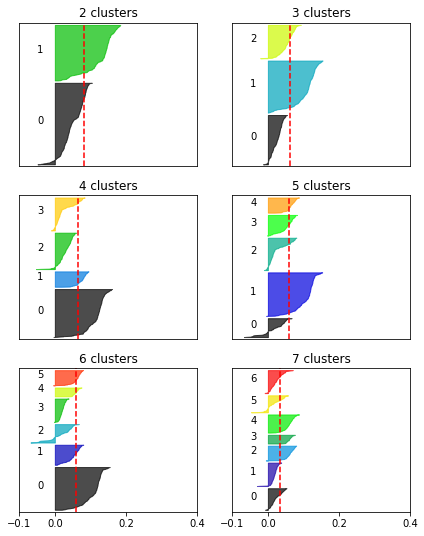

In [7]:
sc = SpectralClustering(affinity='nearest_neighbors',n_neighbors=80,n_clusters=2).fit(X);
Wnn = sc.affinity_matrix_
run_method(SClabeler(Wnn))

# Spectral clustering (RBF similarity)

S score with 2 clusters is 0.08082462416760977
[234 400]
S score with 3 clusters is 0.07142282493864428
[221 226 187]
S score with 4 clusters is 0.06602686870962853
[192 100 226 116]
S score with 5 clusters is 0.050634662634301386
[194 114 115 111 100]
S score with 6 clusters is 0.05615944149764224
[114  60  93 101  71 195]
S score with 7 clusters is 0.02945677962973199
[141 108  94  90  96  61  44]


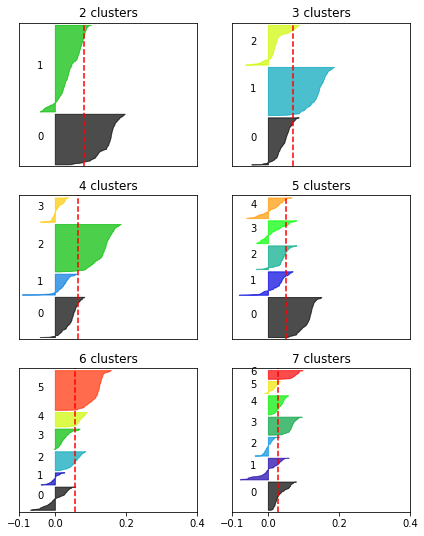

In [8]:
sc = SpectralClustering(affinity='rbf',gamma=5e-5,n_clusters=2).fit(X);
Wrbf = sc.affinity_matrix_
run_method(SClabeler(Wrbf))

# K-means clustering

S score with 2 clusters is 0.0805207550050964
[404 230]
S score with 3 clusters is 0.07209402805589911
[232 175 227]
S score with 4 clusters is 0.0693265497721069
[186 225  64 159]
S score with 5 clusters is 0.06608615454525946
[ 66 220  54 116 178]
S score with 6 clusters is 0.06519567660728832
[115  73 109  44  72 221]
S score with 7 clusters is 0.04523138915609022
[ 73  55  53 101  54 107 191]


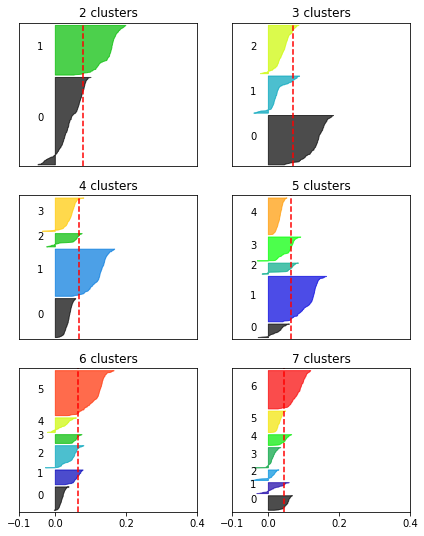

In [9]:
run_method(KMlabeler())

In [10]:
labels = SClabeler(Wrbf)(5)
patient_cluster(ID, labels, "patient_cluster_5_rbf.csv")